In [309]:
import numpy as np
import math
from math import floor
import pandas as pd
import plotly.graph_objects as go
from matplotlib import pyplot as plt
import scipy
import time
import torch
import gpytorch
from gpytorch.kernels import Kernel, RBFKernel, ProductKernel

from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, r2_score

from sklearn.gaussian_process import GaussianProcessRegressor, GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF, ExpSineSquared, RationalQuadratic

from sklearn.linear_model import LinearRegression

from scipy.stats import t

import xgboost as xgb

import os
smoke_test = ('CI' in os.environ)

## To Do:

- Test out basic regressors
    - Models:
        - 1-D KISS-GP regression
        - Gaussian Process Regressor: https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.GaussianProcessRegressor.html
        - Linear Regression
        - (XGBoostRegressor)
    - Dummy Dataset sizes:
        - 100
        - 1000
        - 10000
        - 100000

```
- Test out multidimensional regressors
    - Models:
        - Multidimensional KISS-GP (SKIP)
        - Gaussian Process Regressor: https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.GaussianProcessRegressor.html
        - Linear Regression
        - (XGBoostRegressor)
    - Dummy Dataset sizes:
        - 1000 x 1
        - 1000 x 2
        - 1000 x 3
        - 1000 x 4
- Test out multidimensional classifiers on heart disease dataset \*<b>continuous variables only</b>\*
    - Models:
        - GridInterpolationVariationalStrategy
        - Gaussian Process Classifier: https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.GaussianProcessClassifier.html
```


- Test out continuous classifiers
    - Models:
        - GridInterpolationVariationalStrategy (Continuous Only)
        - VariationalStrategy (Continuous Only AND Continuous + Categorical)
        - Gaussian Process Classifier: https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.GaussianProcessClassifier.html (Continuous Only AND Continuous + Categorical)
    - Datasets
        - Heart Disease: 1 Continuous Variable
        - Heart Disease: 2 Continuous Variables
        - Heart Disease: 3 Continuous Variables
        - Heart Disease: 4 Continuous Variables
        - Heart Disease: 5 Continuous Variables

- Test out full classifiers
    - Models:
        - VariationalStrategy
        - Gaussian Process Classifier: https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.GaussianProcessClassifier.html (Continuous Only AND Continuous + Categorical)
    - Datasets
        - Heart Disease: (Continuous + Categorical)


- Metrics:
    - Accuracy
    - Time

## Datasets

In [369]:
def dummy_dataset(n,multiplier=1,f_type='sinusoid'):

    if f_type == 'sinusoid':
        
        def _make_sinusoid_function(n_terms=10, seed=42):
            np.random.seed(seed)
            freqs = np.random.uniform(0.5, 3, n_terms)
            phases = np.random.uniform(0, 2*np.pi, n_terms)
            amps = np.random.uniform(0.1, 1.0, n_terms)
        
            def f(x):
                y = np.zeros_like(x)
                for a, f_, p in zip(amps, freqs, phases):
                    y += a * np.sin(f_ * x + p)
                return y
            
            return f

        
        f = _make_sinusoid_function(n_terms=15)
        train_x = np.random.rand(n) * 30
        train_y = f(train_x)
        test_x = np.linspace(0,30,200)
        test_y = f(test_x)

        train_x = torch.tensor(train_x)
        train_y = torch.tensor(train_y)
        test_x = torch.tensor(test_x)
        test_y = torch.tensor(test_y)


    elif f_type == 'sin':
        train_x = torch.rand(n) * 20 * np.pi
        train_y = multiplier*torch.sin(train_x) + train_x / 3
    
        test_x = torch.linspace(0, 20 * np.pi, 200)
        test_y = multiplier*torch.sin(test_x) + test_x / 3

    train_x, idx_train = torch.sort(train_x)
    train_y = train_y[idx_train]

    test_x, idx_test = torch.sort(test_x)
    test_y = test_y[idx_test]

    return train_x, test_x, train_y, test_y

In [3]:
def heart_disease_dataset(df,continuous_cols,categorical_cols=None):

    x_cont = df[continuous_cols].values
    if categorical_cols is not None:
        x_cat = df[categorical_cols].values
        
    y = df['target'].values

    scaler = MinMaxScaler(feature_range=(-1, 1))
    x_cont = scaler.fit_transform(x_cont)

    if categorical_cols is not None:
        train_x_cont, test_x_cont, train_x_cat, test_x_cat, train_y, test_y = train_test_split(x_cont, x_cat, y, test_size=0.3, random_state=42)
    else:
        train_x_cont, test_x_cont, train_y, test_y = train_test_split(x_cont, y, test_size=0.3, random_state=42)
    
    train_x_cont = torch.tensor(train_x_cont, dtype=torch.float32)
    test_x_cont = torch.tensor(test_x_cont, dtype=torch.float32)
    train_y = torch.tensor(train_y, dtype=torch.float32)
    test_y = torch.tensor(test_y, dtype=torch.float32)
    
    if categorical_cols is not None:
        train_x_cat = torch.tensor(train_x_cat, dtype=torch.float32)
        test_x_cat = torch.tensor(test_x_cat, dtype=torch.float32)
        return train_x_cont, test_x_cont, train_x_cat, test_x_cat, train_y, test_y

    else:
        return train_x_cont, test_x_cont, train_y, test_y

In [4]:
train_x, test_x, train_y, test_y = dummy_dataset(1000)

In [5]:
path = "heart_disease.csv"
df = pd.read_csv(path)
continuous_cols = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
categorical_cols = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']

train_x, test_x, train_y, test_y = heart_disease_dataset(df, continuous_cols)

In [6]:
train_x_cont, test_x_cont, train_x_cat, test_x_cat, train_y, test_y = heart_disease_dataset(df, continuous_cols, categorical_cols)

## 1-D Regressors

### Helper Functions

In [422]:
class GPRegressionModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPRegressionModel, self).__init__(train_x, train_y, likelihood)

        # SKI requires a grid size hyperparameter. This util can help with that. Here we are using a grid that has the same number of points as the training data (a ratio of 1.0). Performance can be sensitive to this parameter, so you may want to adjust it for your own problem on a validation set.
        grid_size = gpytorch.utils.grid.choose_grid_size(train_x,1.0)

        self.mean_module = gpytorch.means.ConstantMean().double()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.GridInterpolationKernel(
                gpytorch.kernels.RBFKernel().double(),
                grid_size=grid_size,
                num_dims=1
            )
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)




def run_kiss_gp_regression(train_x,test_x,train_y,test_y,training_iterations=30):

    torch.set_default_dtype(torch.float64)

    train_x = train_x.double()
    train_y = train_y.double()
    test_x = test_x.double()
    test_y = test_y.double()

    start = time.time()
    
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    model = GPRegressionModel(train_x, train_y, likelihood)

    # Find optimal model hyperparameters
    model.train()
    likelihood.train()
    
    # Use the adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters
    
    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
    
    for i in range(training_iterations):
        optimizer.zero_grad()
        output = model(train_x)
        loss = -mll(output, train_y)
        loss.backward()
        optimizer.step()


    compute_time = time.time() - start


    # Put model & likelihood into eval mode
    model.eval()
    likelihood.eval()
    
    # Initalize plot
    f, ax = plt.subplots(1, 1, figsize=(4, 3))
    
    # The gpytorch.settings.fast_pred_var flag activates LOVE (for fast variances)
    # See https://arxiv.org/abs/1803.06058
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        prediction = likelihood(model(test_x))
        mean = prediction.mean
        # Get lower and upper predictive bounds
        lower, upper = prediction.confidence_region()


    # accuracy = np.sqrt( np.sum((mean.numpy() - test_y.numpy())**2) / len(test_y))
    accuracy = r2_score(test_y,mean)
    
    # Plot the training data as black stars
    def ax_plot():
        if smoke_test: return  # this is for running the notebook in our testing framework
    
        ax.plot(train_x.detach().numpy(), train_y.detach().numpy(), 'k*')
        # Plot predictive means as blue line
        ax.plot(test_x.detach().numpy(), mean.detach().numpy(), 'b')
        # Plot confidence bounds as lightly shaded region
        ax.fill_between(test_x.detach().numpy(), lower.detach().numpy(), upper.detach().numpy(), alpha=0.5)
        # ax.set_ylim([-3, 3])
        ax.legend(['Observed Data', 'Mean', 'Confidence'])
        ax.set_title('KISS-GP Regression')
    
    ax_plot()

    return accuracy, mean.numpy(), test_y.numpy(), compute_time


def run_sklearn_GP_regression(train_x, test_x, train_y, test_y, kernel_length_scale=1.0, length_scale_bounds=(1e-5,1e3)):

    train_x, test_x, train_y, test_y = train_x.numpy().reshape(-1,1), test_x.numpy().reshape(-1,1), train_y.numpy(), test_y.numpy()

    start = time.time()
    kernel = RBF(length_scale=kernel_length_scale,length_scale_bounds=(0, 1e3))
    gpr = GaussianProcessRegressor(kernel=kernel).fit(train_x, train_y)

    compute_time = time.time() - start

    prediction, pred_std = gpr.predict(test_x, return_std=True)
    
    accuracy = gpr.score(test_x, test_y)

    lower = prediction - 1.96 * pred_std
    upper = prediction + 1.96 * pred_std

    # Initalize plot
    f, ax = plt.subplots(1, 1, figsize=(4, 3))
    
    # Plot the training data as black stars
    def ax_plot():
    
        ax.plot(train_x.reshape(-1), train_y, 'k*')
        # Plot predictive means as blue line
        ax.plot(test_x.reshape(-1), prediction, 'b')
        # Plot confidence bounds as lightly shaded region
        plt.fill_between(test_x.reshape(-1),lower,upper,alpha=0.3,)
        # ax.set_ylim([-3, 3])
        ax.legend(['Observed Data', 'Mean', 'Confidence'])
        ax.set_title('Scikit Learn GP Regression')
    
    ax_plot()
    
    return accuracy, prediction, test_y, compute_time


def run_sklearn_linear_regression(train_x, test_x, train_y, test_y):

    train_x, test_x, train_y, test_y = train_x.numpy(), test_x.numpy(), train_y.numpy(), test_y.numpy()

    start = time.time()
    model = LinearRegression()
    model.fit(train_x.reshape(-1,1),train_y)

    compute_time = time.time() - start

    prediction = model.predict(test_x.reshape(-1,1))

    # Confidence interval for each prediction
    n = len(train_x)
    se = np.sqrt(np.sum((prediction - test_y)**2) / (n - 2))
    t_statistic = t.ppf(1 - 0.16/2, df=n-2)

    mean = np.mean(train_x)
    var =  np.var(train_x)
    
    pred_std = se * np.sqrt(1/n + (test_x - mean)**2 / var)
    
    accuracy = model.score(test_x.reshape(-1,1), test_y)

    lower = prediction - t_statistic * pred_std
    upper = prediction + t_statistic * pred_std

    # Initalize plot
    f, ax = plt.subplots(1, 1, figsize=(4, 3))
    
    # Plot the training data as black stars
    def ax_plot():
    
        ax.plot(train_x.reshape(-1), train_y, 'k*')
        # Plot predictive means as blue line
        ax.plot(test_x.reshape(-1), prediction, 'b')
        # Plot confidence bounds as lightly shaded region
        plt.fill_between(test_x.reshape(-1),lower,upper,alpha=0.3,)
        # ax.set_ylim([-3, 3])
        ax.legend(['Observed Data', 'Mean', 'Confidence'])
        ax.set_title('Scikit Linear Regression')
    
    ax_plot()
    
    return accuracy, prediction, test_y, compute_time



def run_xgboost_regression(train_x, test_x, train_y, test_y):

    train_x, test_x, train_y, test_y = train_x.numpy(), test_x.numpy(), train_y.numpy(), test_y.numpy()


    params_base = {'max_depth': 3, 'learning_rate': 0.1}
    
    
    start = time.time()
    model = xgb.XGBRegressor(objective='reg:squarederror')
    model.fit(train_x.reshape(-1,1),train_y)

    compute_time = time.time() - start

    prediction = model.predict(test_x.reshape(-1,1))
    
    accuracy = model.score(test_x.reshape(-1,1), test_y)


    # Train lower quantile
    model_lower = xgb.XGBRegressor(objective='reg:quantileerror', quantile_alpha=0.16, **params_base)
    model_lower.fit(train_x.reshape(-1,1), train_y)
    
    # Train upper quantile
    model_upper = xgb.XGBRegressor(objective='reg:quantileerror', quantile_alpha=0.84, **params_base)
    model_upper.fit(train_x.reshape(-1,1), train_y)
    
    # Predict
    lower = model_lower.predict(test_x.reshape(-1,1))
    upper = model_upper.predict(test_x.reshape(-1,1))

    # Initalize plot
    f, ax = plt.subplots(1, 1, figsize=(4, 3))
    
    # Plot the training data as black stars
    def ax_plot():
    
        ax.plot(train_x.reshape(-1), train_y, 'k*')
        # Plot predictive means as blue line
        ax.plot(test_x.reshape(-1), prediction, 'b')
        # Plot confidence bounds as lightly shaded region
        plt.fill_between(test_x.reshape(-1),lower,upper,alpha=0.3,)
        # ax.set_ylim([-3, 3])
        ax.legend(['Observed Data', 'Mean', 'Confidence'])
        ax.set_title('XGBoost Regressor')
    
    ax_plot()
    
    return accuracy, prediction, test_y, compute_time

### Datasets

In [411]:
# Generate Data
multiplier=8
f_type='sinusoid' # sinusoid, sin
train_x_10, test_x_10, train_y_10, test_y_10 = dummy_dataset(10,multiplier=multiplier,f_type=f_type)
train_x_100, test_x_100, train_y_100, test_y_100 = dummy_dataset(100,multiplier=multiplier,f_type=f_type)
train_x_1000, test_x_1000, train_y_1000, test_y_1000 = dummy_dataset(1000,multiplier=multiplier,f_type=f_type)
train_x_10000, test_x_10000, train_y_10000, test_y_10000 = dummy_dataset(10000,multiplier=multiplier,f_type=f_type)
train_x_100000, test_x_100000, train_y_100000, test_y_100000 = dummy_dataset(100000,multiplier=multiplier,f_type=f_type)

### 10 Datapoints

C:\Users\peterdb1\Anaconda3\envs\kiss-gp\lib\site-packages\sklearn\gaussian_process\kernels.py:357: RuntimeWarning: divide by zero encountered in log
  return np.log(np.vstack(bounds))


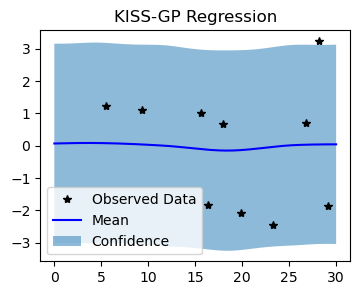

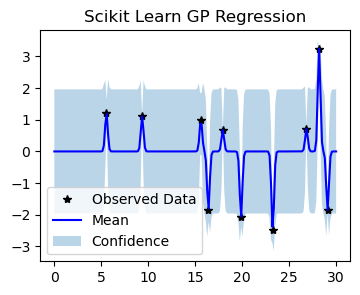

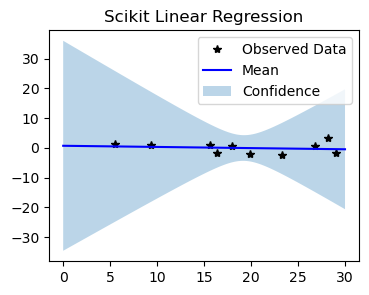

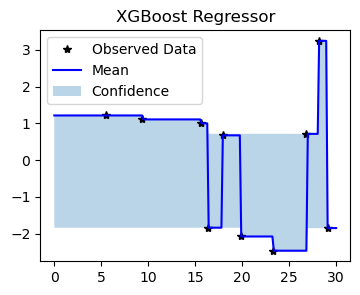

In [423]:
train_x = train_x_10
test_x = test_x_10
train_y = train_y_10
test_y = test_y_10

# 1D Kiss-GP Regressor
accuracy_kgp_10, preds_kgp_10, truth_kgp_10, compute_time_kgp_10 = run_kiss_gp_regression(train_x=train_x,test_x=test_x,
                                                              train_y=train_y,test_y=test_y,
                                                              training_iterations=30)

# Scikit-Learn Gaussian Process Regressor (https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.GaussianProcessRegressor.html)
accuracy_gpr_10, preds_gpr_10, truth_gpr_10, compute_time_gpr_10 = run_sklearn_GP_regression(train_x=train_x,test_x=test_x,
                                                                 train_y=train_y,test_y=test_y,
                                                                 kernel_length_scale=1.0,
                                                                 length_scale_bounds=(1e-5, 1e3))

# Linear Regression
accuracy_lr_10, preds_lr_10, truth_lr_10, compute_time_lr_10 = run_sklearn_linear_regression(train_x=train_x,test_x=test_x,
                                                                     train_y=train_y,test_y=test_y)

# XGBoost Regression
accuracy_xgb_10, preds_xgb_10, truth_xgb_10, compute_time_xgb_10 = run_xgboost_regression(train_x=train_x,test_x=test_x,
                                                              train_y=train_y,test_y=test_y)

### 100 Datapoints

C:\Users\peterdb1\Anaconda3\envs\kiss-gp\lib\site-packages\sklearn\gaussian_process\kernels.py:357: RuntimeWarning: divide by zero encountered in log
  return np.log(np.vstack(bounds))


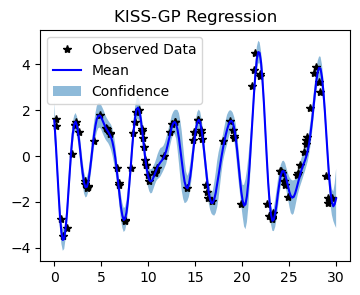

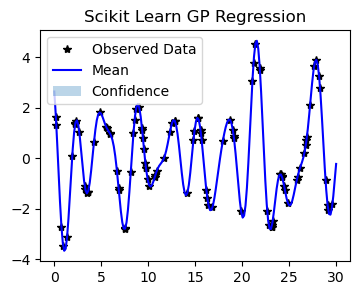

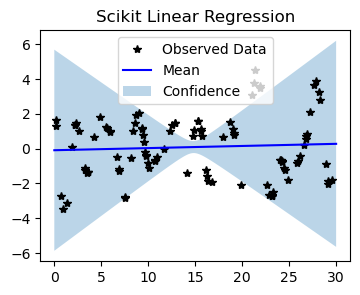

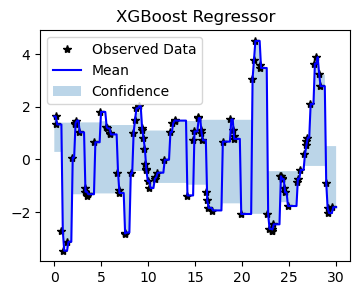

In [424]:
train_x = train_x_100
test_x = test_x_100
train_y = train_y_100
test_y = test_y_100

# 1D Kiss-GP Regressor
accuracy_kgp_100, preds_kgp_100, truth_kgp_100, compute_time_kgp_100 = run_kiss_gp_regression(train_x=train_x,test_x=test_x,
                                                              train_y=train_y,test_y=test_y,
                                                              training_iterations=30)

# Scikit-Learn Gaussian Process Regressor (https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.GaussianProcessRegressor.html)
accuracy_gpr_100, preds_gpr_100, truth_gpr_100, compute_time_gpr_100 = run_sklearn_GP_regression(train_x=train_x,test_x=test_x,
                                                                 train_y=train_y,test_y=test_y,
                                                                 kernel_length_scale=1.0,
                                                                 length_scale_bounds=(1e-3, 1e3))

# Linear Regression
accuracy_lr_100, preds_lr_100, truth_lr_100, compute_time_lr_100 = run_sklearn_linear_regression(train_x=train_x,test_x=test_x,
                                                                     train_y=train_y,test_y=test_y)

# XGBoost Regression
accuracy_xgb_100, preds_xgb_100, truth_xgb_100, compute_time_xgb_100 = run_xgboost_regression(train_x=train_x,test_x=test_x,
                                                              train_y=train_y,test_y=test_y)

### 1000 Datapoints

C:\Users\peterdb1\Anaconda3\envs\kiss-gp\lib\site-packages\sklearn\gaussian_process\kernels.py:357: RuntimeWarning: divide by zero encountered in log
  return np.log(np.vstack(bounds))


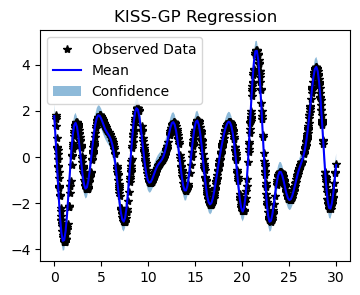

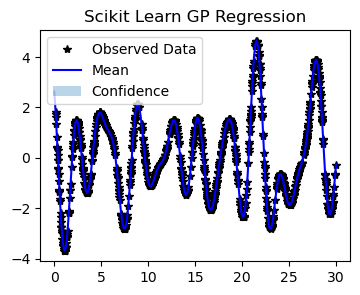

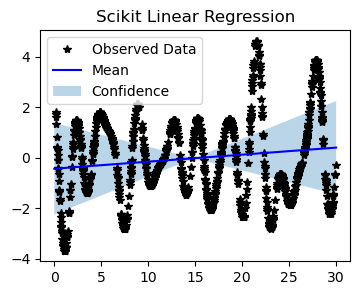

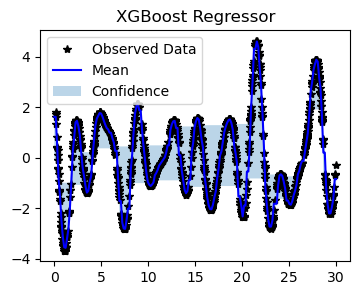

In [425]:
train_x = train_x_1000
test_x = test_x_1000
train_y = train_y_1000
test_y = test_y_1000

# 1D Kiss-GP Regressor
accuracy_kgp_1000, preds_kgp_1000, truth_kgp_1000, compute_time_kgp_1000 = run_kiss_gp_regression(train_x=train_x,test_x=test_x,
                                                              train_y=train_y,test_y=test_y,
                                                              training_iterations=30)

# Scikit-Learn Gaussian Process Regressor (https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.GaussianProcessRegressor.html)
accuracy_gpr_1000, preds_gpr_1000, truth_gpr_1000, compute_time_gpr_1000 = run_sklearn_GP_regression(train_x=train_x,test_x=test_x,
                                                                 train_y=train_y,test_y=test_y,
                                                                 kernel_length_scale=1.0,
                                                                 length_scale_bounds=(1e-5, 1e3))

# Linear Regression
accuracy_lr_1000, preds_lr_1000, truth_lr_1000, compute_time_lr_1000 = run_sklearn_linear_regression(train_x=train_x,test_x=test_x,
                                                                     train_y=train_y,test_y=test_y)

# XGBoost Regression
accuracy_xgb_1000, preds_xgb_1000, truth_xgb_1000, compute_time_xgb_1000 = run_xgboost_regression(train_x=train_x,test_x=test_x,
                                                              train_y=train_y,test_y=test_y)

### 10000 Datapoints

C:\Users\peterdb1\Anaconda3\envs\kiss-gp\lib\site-packages\sklearn\gaussian_process\kernels.py:357: RuntimeWarning: divide by zero encountered in log
  return np.log(np.vstack(bounds))


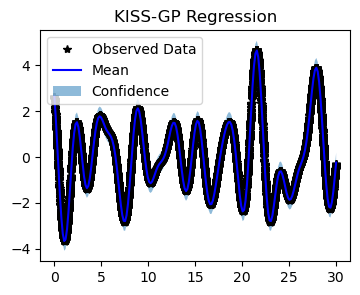

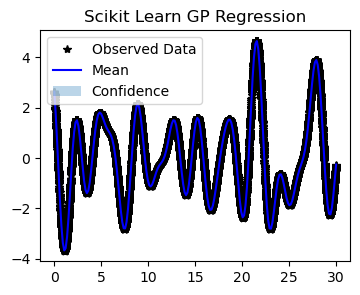

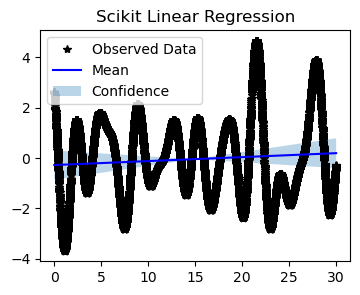

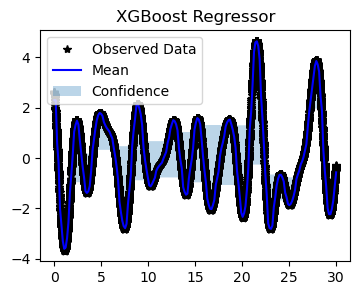

In [426]:
train_x = train_x_10000
test_x = test_x_10000
train_y = train_y_10000
test_y = test_y_10000

# 1D Kiss-GP Regressor
accuracy_kgp_10000, preds_kgp_10000, truth_kgp_10000, compute_time_kgp_10000 = run_kiss_gp_regression(train_x=train_x,test_x=test_x,
                                                              train_y=train_y,test_y=test_y,
                                                              training_iterations=30)

# Scikit-Learn Gaussian Process Regressor (https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.GaussianProcessRegressor.html)
accuracy_gpr_10000, preds_gpr_10000, truth_gpr_10000, compute_time_gpr_10000 = run_sklearn_GP_regression(train_x=train_x,test_x=test_x,
                                                                 train_y=train_y,test_y=test_y,
                                                                 kernel_length_scale=1.0,
                                                                 length_scale_bounds=(1e-5, 1e3))

# Linear Regression
accuracy_lr_10000, preds_lr_10000, truth_lr_10000, compute_time_lr_10000 = run_sklearn_linear_regression(train_x=train_x,test_x=test_x,
                                                                     train_y=train_y,test_y=test_y)

# XGBoost Regression
accuracy_xgb_10000, preds_xgb_10000, truth_xgb_10000, compute_time_xgb_10000 = run_xgboost_regression(train_x=train_x,test_x=test_x,
                                                              train_y=train_y,test_y=test_y)

### Results

In [427]:
kiss_gp_accuracies = np.array([accuracy_kgp_10,accuracy_kgp_100,accuracy_kgp_1000,accuracy_kgp_10000])
kiss_gp_times = np.array([compute_time_kgp_10,compute_time_kgp_100,compute_time_kgp_1000,compute_time_kgp_10000])

gp_reg_accuracies = np.array([accuracy_gpr_10, accuracy_gpr_100, accuracy_gpr_1000, accuracy_gpr_10000])
gp_reg_times = np.array([compute_time_gpr_10, compute_time_gpr_100, compute_time_gpr_1000, compute_time_gpr_10000])

lin_reg_accuracies = np.array([accuracy_lr_10, accuracy_lr_100, accuracy_lr_1000, accuracy_lr_10000])
lin_reg_times = np.array([compute_time_lr_10, compute_time_lr_100, compute_time_lr_1000, compute_time_lr_10000])

xgb_accuracies = np.array([accuracy_xgb_10, accuracy_xgb_100, accuracy_xgb_1000, accuracy_xgb_10000])
xgb_times = np.array([compute_time_xgb_10, compute_time_xgb_100, compute_time_xgb_1000, compute_time_xgb_10000])

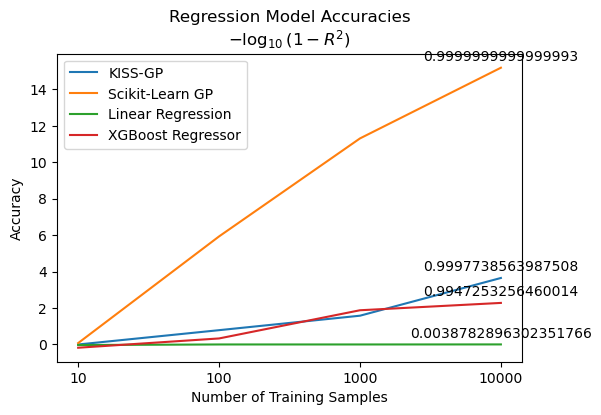

In [455]:
plt.figure(figsize=(6,4))

plt.annotate(kiss_gp_accuracies[-1], (3, -np.log10(1 - kiss_gp_accuracies[-1])), textcoords="offset points", xytext=(0,5), ha='center')
plt.annotate(gp_reg_accuracies[-1], (3, -np.log10(1 - gp_reg_accuracies[-1])), textcoords="offset points", xytext=(0,5), ha='center')
plt.annotate(lin_reg_accuracies[-1], (3, -np.log10(1 - lin_reg_accuracies[-1])), textcoords="offset points", xytext=(0,5), ha='center')
plt.annotate(xgb_accuracies[-1], (3, -np.log10(1 - xgb_accuracies[-1])), textcoords="offset points", xytext=(0,5), ha='center')

plt.plot(-np.log10(1 - kiss_gp_accuracies),label='KISS-GP')
plt.plot(-np.log10(1 - gp_reg_accuracies),label='Scikit-Learn GP')
plt.plot(-np.log10(1 - lin_reg_accuracies),label='Linear Regression')
plt.plot(-np.log10(1 - xgb_accuracies),label='XGBoost Regressor')
plt.xlabel('Number of Training Samples')
plt.xticks(ticks=[0,1,2,3],labels=[10,100,1000,10000])
plt.ylabel('Accuracy')
plt.title('Regression Model Accuracies\n$-\log_{10}(1-R^2)$')
plt.legend()
plt.show()

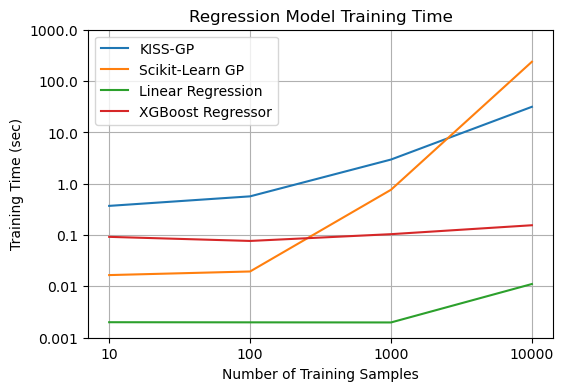

In [471]:
plt.figure(figsize=(6,4))
plt.plot(np.log10(kiss_gp_times),label='KISS-GP')
plt.plot(np.log10(gp_reg_times),label='Scikit-Learn GP')
plt.plot(np.log10(lin_reg_times),label='Linear Regression')
plt.plot(np.log10(xgb_times),label='XGBoost Regressor')
plt.xlabel('Number of Training Samples')
plt.xticks(ticks=[0,1,2,3],labels=[10,100,1000,10000])
plt.yticks(ticks=np.arange(-3,4),labels=[10**float(i) for i in np.arange(-3,4)])
plt.ylabel('Training Time (sec)')
plt.title('Regression Model Training Time')
plt.legend()
plt.grid()
plt.show()

## Continuous Classifiers

### Helper Functions

In [845]:
class KISSGPClassifier(gpytorch.models.ApproximateGP):
    def __init__(self, grid_size, grid_bounds, d_input):
        total_inducing = grid_size ** d_input
        variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(num_inducing_points=total_inducing)
        variational_strategy = gpytorch.variational.GridInterpolationVariationalStrategy(
            self,
            grid_size=grid_size,
            grid_bounds=grid_bounds,
            variational_distribution=variational_distribution
        )
        super().__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(ard_num_dims=d_input)
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# === Training and Evaluation ===
def run_kissgp_continuous(df, continuous_cols, target_col, grid_size=5):
    X = df[continuous_cols].values
    y = df[target_col].values

    scaler = MinMaxScaler(feature_range=(-1, 1))
    X = scaler.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    train_x = torch.tensor(X_train, dtype=torch.float32)
    test_x = torch.tensor(X_test, dtype=torch.float32)
    train_y = torch.tensor(y_train, dtype=torch.float32)
    test_y = torch.tensor(y_test, dtype=torch.float32)

    d_input = train_x.shape[1]
    grid_bounds = [(-1.0, 1.0)] * d_input

    start = time.time()
    
    model = KISSGPClassifier(grid_size=grid_size, grid_bounds=grid_bounds, d_input=d_input)
    likelihood = gpytorch.likelihoods.BernoulliLikelihood()

    model.train()
    likelihood.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=train_y.size(0))

    for i in range(100):
        optimizer.zero_grad()
        output = model(train_x)
        loss = -mll(output, train_y)
        loss.backward()
        optimizer.step()

    compute_time = time.time() - start

    model.eval()
    likelihood.eval()
    with torch.no_grad():
        preds = likelihood(model(test_x)).mean
        pred_probs = preds.numpy()
        pred_labels = (pred_probs > 0.5).astype(int)
        accuracy = (pred_labels == test_y.numpy()).mean()

    cm = confusion_matrix(test_y.numpy(), pred_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Disease", "Disease"])
    fig, ax = plt.subplots(figsize=(3, 3))
    disp.plot(cmap='Greens', ax=ax)
    plt.title("Confusion Matrix")
    plt.show()

    return accuracy, pred_probs, test_y.numpy(), compute_time

In [840]:
# === Variational GP with RBF ===
class VariationalGP(gpytorch.models.ApproximateGP):
    def __init__(self, inducing_points, d_cont):
        variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(inducing_points.size(0))
        variational_strategy = gpytorch.variational.VariationalStrategy(
            self, inducing_points, variational_distribution, learn_inducing_locations=True
        )
        super().__init__(variational_strategy)
        self.d_cont = d_cont
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_cont = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(ard_num_dims=d_cont)
        )

    def forward(self, x):
        x_cont = x[:, :self.d_cont]
        x_cat = x[:, self.d_cont:self.d_cont]
        mean_x = self.mean_module(x_cont)
        covar_x = self.covar_cont(x_cont)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)



# === Main pipeline ===
def run_variational_gp(df, continuous_cols, target_col):

    X_cont = df[continuous_cols].values
    y = df[target_col].values

    scaler = MinMaxScaler(feature_range=(-1, 1))
    X_cont = scaler.fit_transform(X_cont)

    d_cont = X_cont.shape[1]

    # Split
    X_train, X_test, y_train, y_test = train_test_split(X_cont, y, test_size=0.2, random_state=42)
    train_x = torch.tensor(X_train, dtype=torch.float32)
    test_x = torch.tensor(X_test, dtype=torch.float32)
    train_y = torch.tensor(y_train, dtype=torch.float32)
    test_y = torch.tensor(y_test, dtype=torch.float32)

    inducing_points = train_x[:64]

    start = time.time()
    
    model = VariationalGP(inducing_points, d_cont=d_cont)
    likelihood = gpytorch.likelihoods.BernoulliLikelihood()

    model.train()
    likelihood.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    mll = gpytorch.mlls.VariationalELBO(likelihood, model, train_y.numel())

    for i in range(100):
        optimizer.zero_grad()
        output = model(train_x)
        loss = -mll(output, train_y)
        loss.backward()
        optimizer.step()

    compute_time = time.time() - start
    
    model.eval()
    likelihood.eval()
    with torch.no_grad():
        preds = likelihood(model(test_x)).mean
        pred_probs = preds.numpy()
        pred_labels = (pred_probs > 0.5).astype(int)
        accuracy = (pred_labels == test_y.numpy()).mean()

    cm = confusion_matrix(test_y.numpy(), pred_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Disease", "Disease"])
    fig, ax = plt.subplots(figsize=(3, 3))
    disp.plot(cmap='Greens', ax=ax)
    plt.title("Confusion Matrix")
    plt.show()

    return accuracy, pred_probs, test_y.numpy(), compute_time

In [841]:
def run_GP_classifier(df, continuous_cols, target_col):
    X_cont = df[continuous_cols].values
    y = df[target_col].values

    scaler = MinMaxScaler(feature_range=(-1, 1))
    X_cont = scaler.fit_transform(X_cont)

    train_x, test_x, train_y, test_y = train_test_split(X_cont, y, test_size=0.3, random_state=42)
    
    
    kernel = RBF(length_scale=1.0)

    start = time.time()
    
    gpc = GaussianProcessClassifier(kernel=kernel, random_state=0)
    gpc.fit(train_x, train_y)

    compute_time = time.time() - start
    
    y_pred = gpc.predict(test_x)
    pred_probs = gpc.predict_proba(test_x)
    
    # Evaluate accuracy
    accuracy = accuracy_score(test_y, y_pred)

    cm = confusion_matrix(test_y, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Disease", "Disease"])
    fig, ax = plt.subplots(figsize=(3, 3))
    disp.plot(cmap='Greens', ax=ax)
    plt.title("Confusion Matrix")
    plt.show()

    return accuracy, pred_probs, test_y, compute_time

### Generate Data

In [867]:
path = "heart_disease.csv"
df = pd.read_csv(path)

continuous_cols = [col for col in df if len(df[col].unique()) > 6]
continuous_cols1 = continuous_cols[:1]
continuous_cols2 = continuous_cols[:2]
continuous_cols3 = continuous_cols[:3]
continuous_cols4 = continuous_cols[:4]
continuous_cols5 = continuous_cols[:5]


# Predefine Lists to Populate
GIVS_cont_accuracy = []
GIVS_cont_preds = []
GIVS_cont_truth = []
GIVS_cont_compute_time = []

VarGP_cont_accuracy = []
VarGP_cont_preds = []
VarGP_cont_truth = []
VarGP_cont_compute_time = []

sk_GP_cont_accuracy = []
sk_GP_cont_preds = []
sk_GP_cont_truth = []
sk_GP_cont_compute_time = []

### 1 Continuous Variable

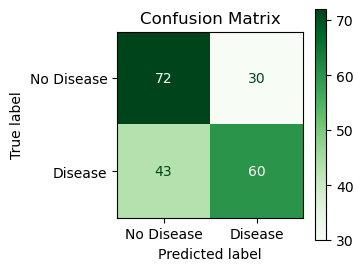

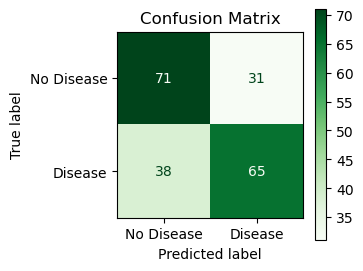

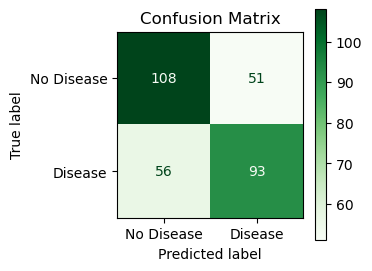

In [868]:
# GridInterpolationVariationalStrategy
accuracy, preds, truth, compute_time = run_kissgp_continuous(
    df,
    continuous_cols=continuous_cols1,
    target_col='target',
    grid_size=5  # 5^3 = 125 inducing points
)
GIVS_cont_accuracy.append(accuracy)
GIVS_cont_preds.append(preds)
GIVS_cont_truth.append(test_y)
GIVS_cont_compute_time.append(compute_time)

# Variational GP
accuracy, preds, truth, compute_time = run_variational_gp(
    df,
    continuous_cols=continuous_cols1,
    target_col='target'
)
VarGP_cont_accuracy.append(accuracy)
VarGP_cont_preds.append(preds)
VarGP_cont_truth.append(test_y)
VarGP_cont_compute_time.append(compute_time)


# scikit-learn Gaussian Process Classifier
accuracy, pred_probs, test_y, compute_time = run_GP_classifier(df, continuous_cols1, 'target')

sk_GP_cont_accuracy.append(accuracy)
sk_GP_cont_preds.append(preds)
sk_GP_cont_truth.append(test_y)
sk_GP_cont_compute_time.append(compute_time)

### 2 Continuous Variables

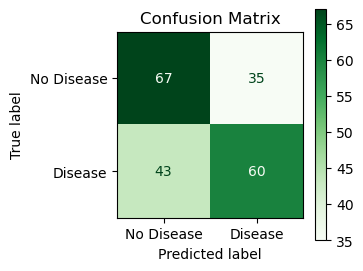

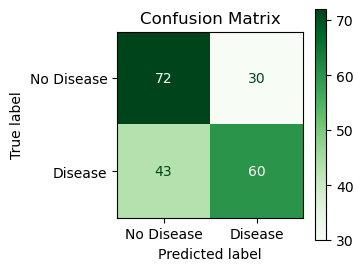

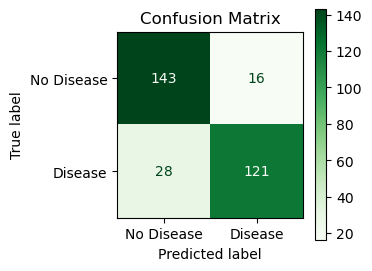

In [869]:
# GridInterpolationVariationalStrategy
accuracy, preds, truth, compute_time = run_kissgp_continuous(
    df,
    continuous_cols=continuous_cols2,
    target_col='target',
    grid_size=5  # 5^3 = 125 inducing points
)
GIVS_cont_accuracy.append(accuracy)
GIVS_cont_preds.append(preds)
GIVS_cont_truth.append(test_y)
GIVS_cont_compute_time.append(compute_time)

# Variational GP
accuracy, preds, truth, compute_time = run_variational_gp(
    df,
    continuous_cols=continuous_cols2,
    target_col='target'
)
VarGP_cont_accuracy.append(accuracy)
VarGP_cont_preds.append(preds)
VarGP_cont_truth.append(test_y)
VarGP_cont_compute_time.append(compute_time)


# scikit-learn Gaussian Process Classifier
accuracy, pred_probs, test_y, compute_time = run_GP_classifier(df, continuous_cols2, 'target')

sk_GP_cont_accuracy.append(accuracy)
sk_GP_cont_preds.append(preds)
sk_GP_cont_truth.append(test_y)
sk_GP_cont_compute_time.append(compute_time)

### 3 Continuous Variables

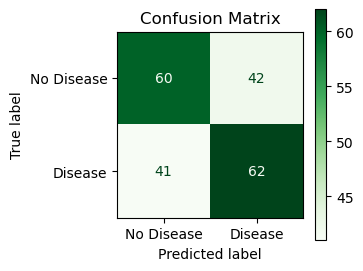

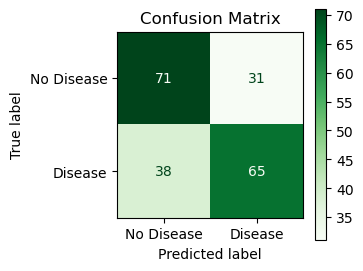

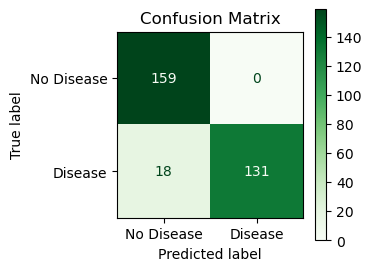

In [870]:
# GridInterpolationVariationalStrategy
accuracy, preds, truth, compute_time = run_kissgp_continuous(
    df,
    continuous_cols=continuous_cols3,
    target_col='target',
    grid_size=5  # 5^3 = 125 inducing points
)
GIVS_cont_accuracy.append(accuracy)
GIVS_cont_preds.append(preds)
GIVS_cont_truth.append(test_y)
GIVS_cont_compute_time.append(compute_time)

# Variational GP
accuracy, preds, truth, compute_time = run_variational_gp(
    df,
    continuous_cols=continuous_cols3,
    target_col='target'
)
VarGP_cont_accuracy.append(accuracy)
VarGP_cont_preds.append(preds)
VarGP_cont_truth.append(test_y)
VarGP_cont_compute_time.append(compute_time)


# scikit-learn Gaussian Process Classifier
accuracy, pred_probs, test_y, compute_time = run_GP_classifier(df, continuous_cols3, 'target')

sk_GP_cont_accuracy.append(accuracy)
sk_GP_cont_preds.append(preds)
sk_GP_cont_truth.append(test_y)
sk_GP_cont_compute_time.append(compute_time)

### 4 Continuous Variables

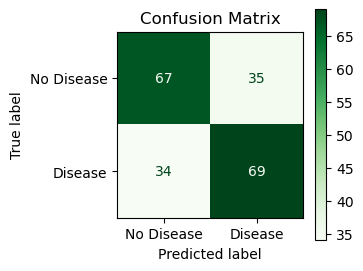

C:\Users\peterdb1\Anaconda3\envs\kiss-gp\lib\site-packages\sklearn\gaussian_process\kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


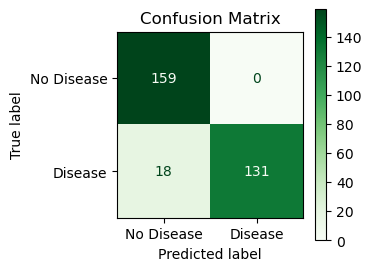

In [871]:
# # GridInterpolationVariationalStrategy
# accuracy, preds, truth, compute_time = run_kissgp_continuous(
#     df,
#     continuous_cols=continuous_cols4,
#     target_col='target',
#     grid_size=5  # 5^3 = 125 inducing points
# )
# GIVS_cont_accuracy.append(accuracy)
# GIVS_cont_preds.append(preds)
# GIVS_cont_truth.append(test_y)
# GIVS_cont_compute_time.append(compute_time)

# Variational GP
accuracy, preds, truth, compute_time = run_variational_gp(
    df,
    continuous_cols=continuous_cols4,
    target_col='target'
)
VarGP_cont_accuracy.append(accuracy)
VarGP_cont_preds.append(preds)
VarGP_cont_truth.append(test_y)
VarGP_cont_compute_time.append(compute_time)


# scikit-learn Gaussian Process Classifier
accuracy, pred_probs, test_y, compute_time = run_GP_classifier(df, continuous_cols4, 'target')

sk_GP_cont_accuracy.append(accuracy)
sk_GP_cont_preds.append(preds)
sk_GP_cont_truth.append(test_y)
sk_GP_cont_compute_time.append(compute_time)

### 5 Continuous Variables

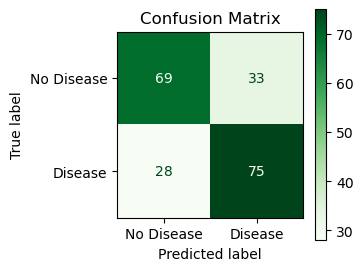

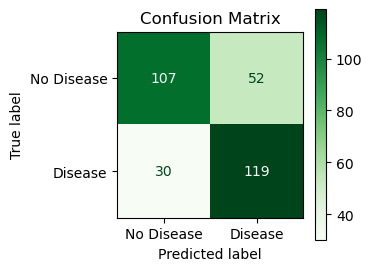

In [872]:
# # GridInterpolationVariationalStrategy
# accuracy, preds, truth, compute_time = run_kissgp_continuous(
#     df,
#     continuous_cols=continuous_cols5,
#     target_col='target',
#     grid_size=5  # 5^3 = 125 inducing points
# )
# GIVS_cont_accuracy.append(accuracy)
# GIVS_cont_preds.append(preds)
# GIVS_cont_truth.append(test_y)
# GIVS_cont_compute_time.append(compute_time)

# Variational GP
accuracy, preds, truth, compute_time = run_variational_gp(
    df,
    continuous_cols=continuous_cols5,
    target_col='target'
)
VarGP_cont_accuracy.append(accuracy)
VarGP_cont_preds.append(preds)
VarGP_cont_truth.append(test_y)
VarGP_cont_compute_time.append(compute_time)


# scikit-learn Gaussian Process Classifier
accuracy, pred_probs, test_y, compute_time = run_GP_classifier(df, continuous_cols5, 'target')

sk_GP_cont_accuracy.append(accuracy)
sk_GP_cont_preds.append(preds)
sk_GP_cont_truth.append(test_y)
sk_GP_cont_compute_time.append(compute_time)

### Tables and Plots

In [882]:
continuous_cols

['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

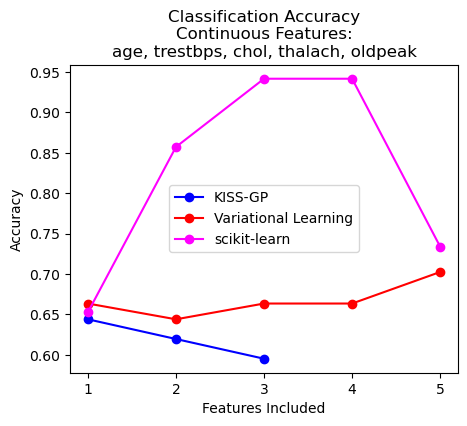

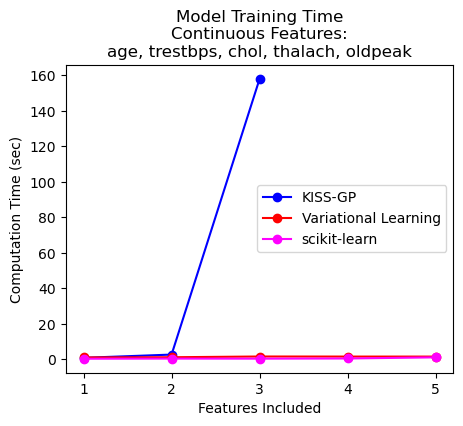

In [891]:
num_features = np.arange(5) + 1

# Plot Accuracies
GIVS_cont_accuracy
VarGP_cont_accuracy
sk_GP_cont_accuracy

plt.figure(figsize=(5,4))
plt.plot(num_features[:3],GIVS_cont_accuracy,'o-',color='blue',label='KISS-GP')
plt.plot(num_features,VarGP_cont_accuracy,'o-',color='red',label='Variational Learning')
plt.plot(num_features,sk_GP_cont_accuracy,'o-',color='magenta',label='scikit-learn')
plt.xlabel('Features Included')
plt.ylabel('Accuracy (%)')
plt.xticks(np.arange(1,6))
plt.title(f'Classification Accuracy\nContinuous Features:\n{", ".join(continuous_cols)}')
plt.legend()
plt.show()

# Plot Times
GIVS_cont_compute_time
VarGP_cont_compute_time
sk_GP_cont_compute_time

plt.figure(figsize=(5,4))
plt.plot(num_features[:3],GIVS_cont_compute_time,'o-',color='blue',label='KISS-GP')
plt.plot(num_features,VarGP_cont_compute_time,'o-',color='red',label='Variational Learning')
plt.plot(num_features,sk_GP_cont_compute_time,'o-',color='magenta',label='scikit-learn')
plt.xlabel('Features Included')
plt.ylabel('Computation Time (sec)')
plt.xticks(np.arange(1,6))
plt.title(f'Model Training Time\nContinuous Features:\n{", ".join(continuous_cols)}')
plt.legend()
plt.show()

# GIVS_cont_preds
# GIVS_cont_truth
# VarGP_cont_preds
# VarGP_cont_truth
# sk_GP_cont_preds
# sk_GP_cont_truth

## Full Classifiers

### Helpfer Functions

In [892]:
# === Hamming Kernel for categorical features ===
class HammingKernel(gpytorch.kernels.Kernel):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def forward(self, x1, x2, diag=False, **params):
        if diag:
            return torch.ones(x1.size(0), dtype=torch.float32, device=x1.device)
        x1 = x1.long()
        x2 = x2.long()
        neq = (x1.unsqueeze(1) != x2.unsqueeze(0)).float()
        hamming_dist = neq.sum(dim=-1)
        return torch.exp(-hamming_dist)

# === Variational GP with RBF × Hamming ===
class VariationalGP_Hamming(gpytorch.models.ApproximateGP):
    def __init__(self, inducing_points, d_cont, d_cat):
        variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(inducing_points.size(0))
        variational_strategy = gpytorch.variational.VariationalStrategy(
            self, inducing_points, variational_distribution, learn_inducing_locations=True
        )
        super().__init__(variational_strategy)
        self.d_cont = d_cont
        self.d_cat = d_cat
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_cont = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(ard_num_dims=d_cont)
        )
        self.covar_cat = HammingKernel()

    def forward(self, x):
        x_cont = x[:, :self.d_cont]
        x_cat = x[:, self.d_cont:self.d_cont + self.d_cat]
        mean_x = self.mean_module(x_cont)
        covar_x = self.covar_cont(x_cont) * self.covar_cat(x_cat)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)



# === Main pipeline ===
def run_variational_gp_with_hamming(df, continuous_cols, categorical_cols, target_col):
    df_encoded = df.copy()
    label_encoders = {}
    for col in categorical_cols:
        le = LabelEncoder()
        df_encoded[col] = le.fit_transform(df_encoded[col])
        label_encoders[col] = le

    X_cont = df_encoded[continuous_cols].values
    X_cat = df_encoded[categorical_cols].values
    y = df_encoded[target_col].values

    scaler = MinMaxScaler(feature_range=(-1, 1))
    X_cont = scaler.fit_transform(X_cont)

    # Stack all inputs
    X_all = np.hstack([X_cont, X_cat])
    d_cont = X_cont.shape[1]
    d_cat = X_cat.shape[1]

    # Split
    X_train, X_test, y_train, y_test = train_test_split(X_all, y, test_size=0.2, random_state=42)
    train_x = torch.tensor(X_train, dtype=torch.float32)
    test_x = torch.tensor(X_test, dtype=torch.float32)
    train_y = torch.tensor(y_train, dtype=torch.float32)
    test_y = torch.tensor(y_test, dtype=torch.float32)

    inducing_points = train_x[:64]

    start = time.time()
    
    model = VariationalGP_Hamming(inducing_points, d_cont=d_cont, d_cat=d_cat)
    likelihood = gpytorch.likelihoods.BernoulliLikelihood()

    model.train()
    likelihood.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    mll = gpytorch.mlls.VariationalELBO(likelihood, model, train_y.numel())

    for i in range(100):
        optimizer.zero_grad()
        output = model(train_x)
        loss = -mll(output, train_y)
        loss.backward()
        optimizer.step()

    compute_time = time.time() - start

    model.eval()
    likelihood.eval()
    with torch.no_grad():
        preds = likelihood(model(test_x)).mean
        pred_probs = preds.numpy()
        pred_labels = (pred_probs > 0.5).astype(int)
        accuracy = (pred_labels == test_y.numpy()).mean()

    cm = confusion_matrix(test_y.numpy(), pred_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Disease", "Disease"])
    fig,ax = plt.subplots(figsize=(3,3))
    disp.plot(cmap='Greens',ax=ax)
    plt.title("Confusion Matrix")
    plt.show()

    return accuracy, pred_probs, test_y.numpy(), compute_time

In [893]:
def run_GP_classifier_with_cats(df, continuous_cols, categorical_cols, target_col='target'):
    
    X_cont = df[continuous_cols].values
    X_cat = df[categorical_cols].values
    y = df[target_col].values

    # Scale continuous features
    scaler = MinMaxScaler(feature_range=(-1, 1))
    X_cont = scaler.fit_transform(X_cont)

    # One-hot encode categorical features
    encoder = OneHotEncoder(handle_unknown='ignore')
    X_cat_encoded = encoder.fit_transform(X_cat).toarray()

    X_all = np.hstack([X_cont,X_cat_encoded])

    train_x, test_x, train_y, test_y = train_test_split(X_all, y, test_size=0.3, random_state=42)
    
    kernel = RBF(length_scale=1.0)

    start = time.time()
    
    gpc = GaussianProcessClassifier(kernel=kernel, random_state=0)
    gpc.fit(train_x, train_y)

    compute_time = time.time() - start
    
    y_pred = gpc.predict(test_x)
    pred_probs = gpc.predict_proba(test_x)
    
    # Evaluate accuracy
    accuracy = accuracy_score(test_y, y_pred)

    cm = confusion_matrix(test_y, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Disease", "Disease"])
    fig,ax = plt.subplots(figsize=(3,3))
    disp.plot(cmap='Greens',ax=ax)
    plt.show()

    return accuracy, pred_probs, test_y, compute_time

### Dataset

In [894]:
path = "heart_disease.csv"
df = pd.read_csv(path)

continuous_cols = [col for col in df if len(df[col].unique()) > 6]
categorical_cols = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']

In [ ]:
df_expanded = pd.concat([df,df,df,df,df])
for i in range(20):
    df_expanded[str(i)] = np.random.rand(df_expanded.shape[0])

### Full Dataset

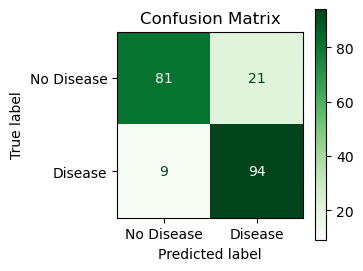

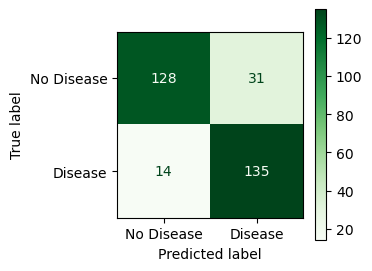

In [896]:
# Variational GP
VarGP_full_accuracy, VarGP_full_preds, VarGP_full_truth, VarGP_full_compute_time = run_variational_gp_with_hamming(
    df,
    continuous_cols=continuous_cols,
    categorical_cols=categorical_cols,
    target_col='target'
)
# scikit-learn Gaussian Process Classifier
sk_GP_full_accuracy, sk_GP_full_preds, sk_GP_full_truth, sk_GP_full_compute_time = run_GP_classifier_with_cats(df, continuous_cols, categorical_cols, 'target')

### Expanded Dataset

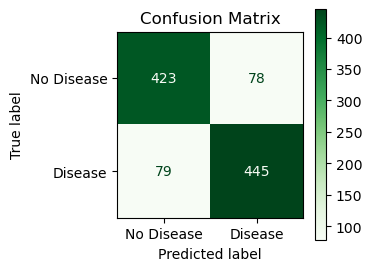

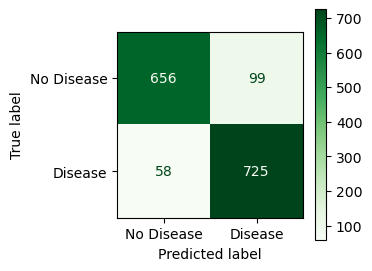

In [921]:
# Variational GP
VarGP_expanded_accuracy, VarGP_expanded_preds, VarGP_expanded_truth, VarGP_expanded_compute_time = run_variational_gp_with_hamming(
    df_expanded,
    continuous_cols=continuous_cols + [str(i) for i in range(20)],
    categorical_cols=categorical_cols,
    target_col='target'
)
# scikit-learn Gaussian Process Classifier
sk_GP_expanded_accuracy, sk_GP_expanded_preds, sk_GP_expanded_truth, sk_GP_expanded_compute_time = run_GP_classifier_with_cats(df_expanded, continuous_cols + [str(i) for i in range(20)], categorical_cols, 'target')

### Tables and Plots

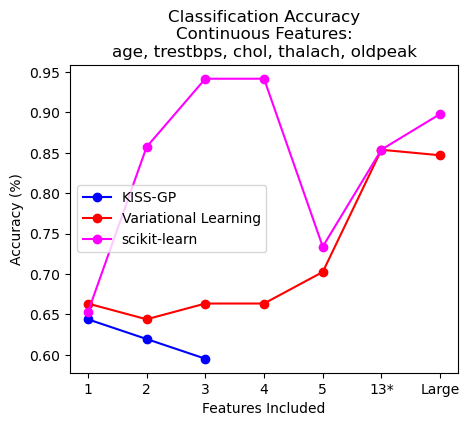

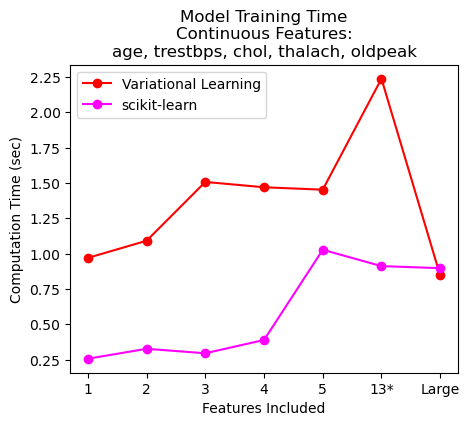

In [935]:
num_features = np.arange(1,8)
labels = ['1','2','3','4','5','13*','Large']

# Plot Accuracies
plt.figure(figsize=(5,4))
plt.plot(num_features[:3],GIVS_cont_accuracy,'o-',color='blue',label='KISS-GP')
plt.plot(num_features,VarGP_cont_accuracy + [VarGP_full_accuracy, VarGP_expanded_accuracy],'o-',color='red',label='Variational Learning')
plt.plot(num_features,sk_GP_cont_accuracy + [sk_GP_full_accuracy, sk_GP_expanded_accuracy],'o-',color='magenta',label='scikit-learn')
plt.xlabel('Features Included')
plt.ylabel('Accuracy (%)')
plt.xticks(ticks=num_features,labels=labels)
plt.title(f'Classification Accuracy\nContinuous Features:\n{", ".join(continuous_cols)}')
plt.legend()
plt.show()


# Plot Times
plt.figure(figsize=(5,4))
# plt.plot(num_features[:3],GIVS_cont_compute_time[:3],'o-',color='blue',label='KISS-GP')
plt.plot(num_features,VarGP_cont_compute_time + [VarGP_full_compute_time, VarGP_expanded_accuracy],'o-',color='red',label='Variational Learning')
plt.plot(num_features,sk_GP_cont_compute_time + [sk_GP_full_compute_time, sk_GP_expanded_accuracy],'o-',color='magenta',label='scikit-learn')
plt.xlabel('Features Included')
plt.ylabel('Computation Time (sec)')
plt.xticks(ticks=num_features,labels=labels)
plt.title(f'Model Training Time\nContinuous Features:\n{", ".join(continuous_cols)}')
plt.legend()
plt.show()

## Extras

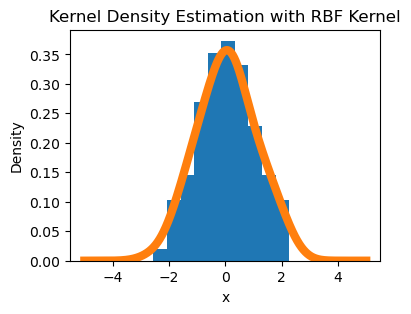

In [954]:
from sklearn.neighbors import KernelDensity
from scipy.interpolate import Rbf

np.random.seed(0)
X = np.random.randn(100, 1)
x_plot = np.linspace(-5, 5, 1000)[:, np.newaxis]

kde_rbf = KernelDensity(kernel='gaussian', bandwidth=0.5)
kde_rbf.fit(X)
log_dens = kde_rbf.score_samples(x_plot)
density_rbf = np.exp(log_dens)

plt.figure(figsize=(4, 3))
plt.hist(X[:,0],density=True,bins=10)
# plt.plot(X[:, 0], np.zeros_like(X[:, 0]), 'o', ms=5, label='Data points')
plt.plot(x_plot[:, 0], density_rbf, '-', linewidth=6, label='KDE with RBF (Gaussian) kernel')

plt.xlabel('x')
plt.ylabel('Density')
plt.title('Kernel Density Estimation with RBF Kernel')
plt.show()